### Import modules

In [1]:
import numpy as np
import pandas as pd
import geopy.distance
import datetime
import matplotlib.pyplot as plt
import gc
import statsmodels.api as sm     
from sklearn import preprocessing  
from sklearn import metrics

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(0)

## Defining functions

### Addressing outliers

In [2]:
def remove_outliers(df, col):
    
    perc_25 = np.percentile(df[col], 25)
    perc_75 = np.percentile(df[col], 75)
    iqr = perc_75 - perc_25
    ll = perc_25 - 1.5*iqr
    ul = perc_75 + 1.5*iqr
    
    print("\n IQR {} \n Lower limit {}\n Upper limit {}".format(iqr, ll, ul))
    print("\n Minimum {} \n Maximum {} \n".format(min(df[col]), max(df[col])))
    
    if min(df[col]) < ll and max(df[col]) > ul:
        print("There are samples which violate both upper limit and lower limit")
        idx = np.where((df[col] < ll) and (df[col] > ul))
        df.drop(idx[0], inplace = True)
        print("Outliers have been removed")

    elif min(df[col]) < ll and max(df[col]) <= ul:
        print("There are samples which violate only lower limit")
        idx = np.where(df[col] < ll)
        df.drop(idx[0], inplace = True)
        print("Outliers have been removed")
    
    elif min(df[col]) >= ll and max(df[col]) > ul:
        print("There are samples which violate only upper limit")
        idx = np.where(df[col] > ul)
        df.drop(idx[0], inplace = True)
        print("Outliers have been removed")
        
    df = df.reset_index()
    df.drop(columns=["index"], axis=1, inplace = True)
    
    return df

### Addressing NaNs and duplicate rows

In [3]:
def drop_rows(df, key_word):
    
    if key_word == 'NaNs':
        df.dropna(inplace = True)
        print("Number of samples after dropping NaNs :",df.shape)
    elif key_word == 'duplicates':
        df.drop_duplicates(inplace = True)
        print("Number of samples after dropping duplicates :",df.shape)
    else:
        print("Please specify correct key-word")
        
    df = df.reset_index()
    df.drop(["index"], axis = 1, inplace = True)
    
    return df

### Adjusting date information 

In [4]:
def adjust_date(df):
        
    df["date_time"] = df.ts.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    df["date"] = df.date_time.apply(lambda x: pd.to_datetime(x.date(), errors = 'coerce'))
    df["time"] = df.date_time.apply(lambda x: x.time())
    df["day"] = df['date'].dt.day_name()
    df["day_indicator"] = df.day.apply(lambda x: 'Weekend' if x in ['Saturday','Sunday'] else 'Weekday')
    df["hour"] = df.time.apply(lambda x: x.hour)
    df["time_indicator"] = df.hour.apply(lambda x: 'Morning' if (x>=5 and x<=11) else ('Afternoon' if (x>=12 and x<=17) else ('Evening' if (x>=18 and x<=21) else 'Night'))) 
    df["week_no"] = df.date.apply(lambda x: x.isocalendar()[1])
    df["month_no"] = df.date.apply(lambda x: x.month)
    df["month_name"] = df.date.apply(lambda x: x.strftime("%b"))
    
    res = df[['number', 'pick_lat', 'pick_lng', 'drop_lat', 'drop_lng', 'date_time', 'date', 'day', 'day_indicator', 'hour', 'time_indicator', 'week_no', 'month_no', 'month_name']]
    return res

### Getting distance travelled per trip

In [5]:
def get_dist(df):
    
    l1 = pd.Series(list(zip(df.pick_lat, df.pick_lng)))
    l2 = pd.Series(list(zip(df.drop_lat, df.drop_lng)))
    l = pd.concat([l1, l2], axis = 1)
    
    df['coords']= l.values.tolist()
    df["dist_km"] = df.coords.apply(lambda x: geopy.distance.geodesic(x[0],x[1]).km)
    df["dist_km"] = df["dist_km"].round(3) 
    
    res = df[["number", "date_time", "date", "day", "day_indicator", "time_indicator", 'week_no', 'month_no', 'month_name', "coords", "dist_km"]]
    
    return res

### Adjusting week-month inforamtion

In [6]:
def adjust_week_month(df):
    
    df["month"] = list(zip(df["month_no"], df["month_name"]))
    
    df.rename(columns = {'day':'day_name'}, inplace = True)
    weekdays_dic ={'Monday': 1, 'Tuesday': 2, 'Wednesday': 3,'Thursday': 4,'Friday': 5,'Saturday': 6,'Sunday': 7}
    df["day_no"] = df.day_name.apply(lambda x: weekdays_dic[x])

    df["day"] = list(zip(df["day_no"], df["day_name"]))
       
    df.drop([], axis = 1, inplace = True)
    
    temp = df[['number', 'date_time', 'date', 'day_no', 'day_name', 'day', 'day_indicator', 'time_indicator', 'week_no', 'month_no', 'month_name', 'month', 'coords','dist_km']]
    
    return temp

### Getting data aggregated at day level basis

In [7]:
def per_day_data(df):
    
    res = []
    
    days = list(df["date"].unique())
    
    for i in range(len(days)):
        temp = df.loc[df["date"]==days[i]]
        num_customers = temp["number"].nunique()
        num_trips = temp.shape[0]
        avg_dist = round(temp["dist_km"].mean(), 3)
        total_dist = round(temp["dist_km"].sum(), 3)
        
        res.append([days[i], num_customers, num_trips, avg_dist, total_dist])
    
    res = pd.DataFrame(res)
    res.columns = ['date', 'num_customers', 'num_trips', 'avg_dist', 'total_dist']
    
    sub_data = df[['date', 'day_no', 'day_name', 'day', 'day_indicator', 'week_no', 'month_no', 'month_name', 'month']]
    
    res_f = pd.merge(sub_data, res, on = 'date', how = 'inner')
    res_f.drop_duplicates(inplace = True)
    res_f = res_f.reset_index()
    res_f.drop(['index'], axis = 1, inplace = True)
    
    res_f["year"] = res_f.date.apply(lambda x: pd.to_datetime(x).year)
    res_f["month_year"] = list(zip(res_f["year"], res_f["month_no"], res_f["month_name"]))
    res_f["week_year"] = list(zip(res_f["year"], res_f["week_no"]))
    
    res_f["ts_indicator"] = range(1, res_f.shape[0] + 1 ,1)
    
    return res_f

### Encoding categorical variables

In [8]:
def categorical_encode(df, col, key_word):
    
    if key_word == 'l_encode':
        le = preprocessing.LabelEncoder() 
        l_encodes = pd.DataFrame(le.fit_transform(df[col]))
        l_encodes.columns = [col + "_encoded"]
        df = pd.concat([df, l_encodes], axis = 1)
        df.drop([col], axis = 1, inplace = True)
    
    elif key_word == 'o_encode':
        o_encodes = pd.get_dummies(df[col]).astype(int)
        df = pd.concat([df, o_encodes], axis = 1)
        df.drop([col], axis = 1, inplace = True)
        
    return df 

### Visualisations for all data

In [9]:
def total_dist_trips(df, grp_by):
    
    temp1 = df[['dist_km', grp_by]]
    temp_dist = temp1.groupby(grp_by).sum()
    temp_dist = temp_dist.reset_index()
    temp_dist.columns = [grp_by,'total_dist']
    
    temp2 = df[['date', grp_by]]
    temp_trip = temp2.groupby(grp_by).count()
    temp_trip = temp_trip.reset_index()
    temp_trip.columns = [grp_by,'total_trips']
    
    plt.figure(figsize=(12,4))   
    
    ax1 = plt.subplot(1, 2, 1)   
    temp_dist.plot.bar(grp_by,'total_dist', rot = 90, ax = ax1)
    plt.ylabel("Total distance")
    plt.title("Total distance per " + grp_by)
    
    ax2 = plt.subplot(1, 2, 2)
    temp_trip.plot.bar(grp_by,'total_trips', rot = 90, ax = ax2)
    plt.ylabel("Total trips")
    plt.title("Total trips per " + grp_by)
  
    plt.tight_layout()
    plt.show()
    

### Visualisations for aggregated data

In [10]:
def aggregated_data_visualisations(df, col, grp_by, size1, size2, key_word):
    
    if key_word == 'all':
        
        plt.figure(figsize = (size1,size2))
        plt.plot(df[col])
        plt.xlabel("Days")
        plt.ylabel(col + " values")
        plt.title(col + " per day")
        plt.show()
    
    else:
        
        df.boxplot(column=[col], by=grp_by, figsize=(size1,size2))
        plt.title("Distribution of " + col)
        plt.ylabel(col)
        plt.xticks(rotation=90)
        plt.show()

In [11]:
path = "/Users/sohinimitra/Documents/Trell/"

### Defining path and loading original data

In [12]:
'''
path = "/Users/sohinimitra/Documents/Trell/"

data = pd.read_csv(path + "data.csv")

print("Number of samples in original data :",data.shape)
data.info()
'''

'\npath = "/Users/sohinimitra/Documents/Trell/"\n\ndata = pd.read_csv(path + "data.csv")\n\nprint("Number of samples in original data :",data.shape)\ndata.info()\n'

### Removing NaNs and duplicates from original data

In [13]:
'''
data = drop_rows(data, 'NaNs')
data = drop_rows(data, 'duplicates')
'''

"\ndata = drop_rows(data, 'NaNs')\ndata = drop_rows(data, 'duplicates')\n"

### Adjusting date in original data

In [14]:
'''
data = adjust_date(data)
'''

'\ndata = adjust_date(data)\n'

#### Note: This operation takes ~15 minutes

### Getting distance travelled per trip in original data

In [15]:
'''
data = get_dist(data)
'''

'\ndata = get_dist(data)\n'

#### Note: This operation takes ~ 20 minutes

In [16]:
'''
data.sample(3)
'''

'\ndata.sample(3)\n'

### Saving data to avoid re-running heavy operations

In [17]:
'''
data.to_csv(path + "data_refined2.csv")
'''

'\ndata.to_csv(path + "data_refined2.csv")\n'

### Loading adjusted data

In [18]:
data_new = pd.read_csv(path + "data_refined2.csv")
data_new.drop(["Unnamed: 0"], axis = 1, inplace = True)
data_new.sample(5)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,number,date_time,date,day,day_indicator,time_indicator,week_no,month_no,month_name,coords,dist_km
820860,46045,2018-07-13 08:50:42,2018-07-13 00:00:00,Friday,Weekday,Morning,28,7,Jul,"[(12.96141, 77.61275), (12.975735, 77.57291)]",4.604
288274,79611,2018-05-11 14:17:51,2018-05-11 00:00:00,Friday,Weekday,Afternoon,19,5,May,"[(12.950994, 77.69665), (12.956408, 77.72466)]",3.098
4088733,48153,2019-01-10 09:37:13,2019-01-10 00:00:00,Thursday,Weekday,Morning,2,1,Jan,"[(12.908217, 77.61017), (12.927774000000001, 7...",4.615
4277204,46958,2019-01-17 21:54:31,2019-01-17 00:00:00,Thursday,Weekday,Evening,3,1,Jan,"[(12.9353695, 77.56087), (12.976664, 77.57126)]",4.705
6326149,33331,2019-03-07 11:22:12,2019-03-07 00:00:00,Thursday,Weekday,Morning,10,3,Mar,"[(12.857168, 77.57419), (12.895938000000001, 7...",4.311


### Adjusting week-month inforamtion

In [19]:
data_new = adjust_week_month(data_new)

### Visualisations on all data

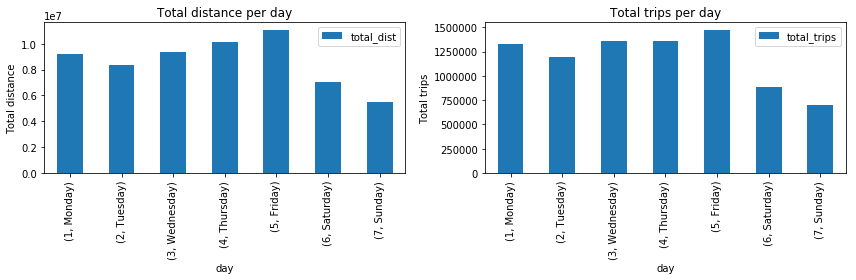

In [20]:
total_dist_trips(data_new, 'day')

#### Note: Number of trips/distance covered is highest on Fridays

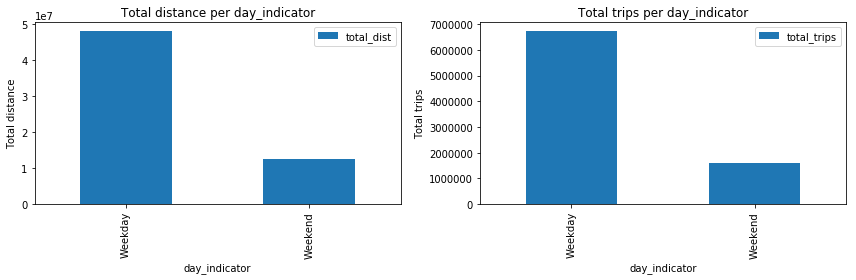

In [21]:
total_dist_trips(data_new, 'day_indicator')

#### Note: Number of trips/distance covered is more on Weekdays

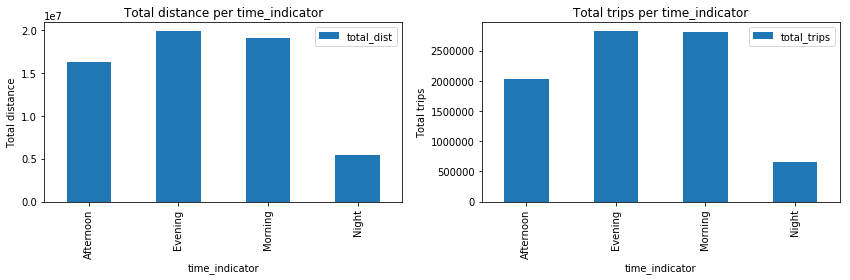

In [22]:
total_dist_trips(data_new, 'time_indicator')

#### Note: Customers tend to travel more during morning (5am-12pm) and evening (6pm-10pm)

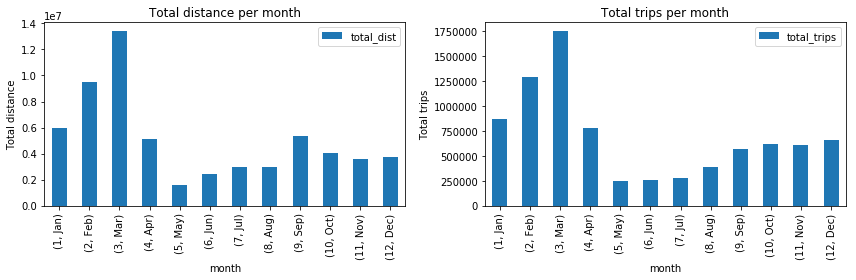

In [23]:
total_dist_trips(data_new, 'month')

#### Note: At a month level, Januray-March have higher number of travels. These travels are in year 2019. Other travels are in 2018. The cab services acquired more trips over time. 

In [24]:
print("Total number of unique customers :",data_new["number"].nunique())

Total number of unique customers : 170371


### Aggregating data

In [25]:
data_new_aggregated = per_day_data(data_new)

### Visualisations on aggregated data

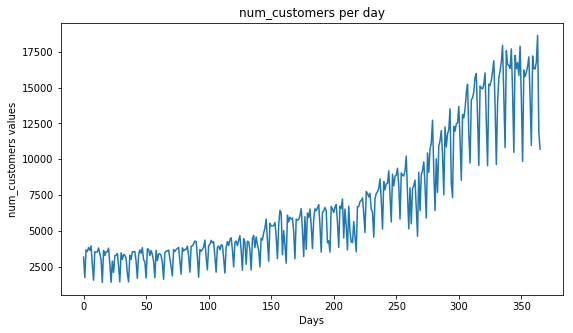

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365
date,2018-04-07 00:00:00,2018-04-08 00:00:00,2018-04-09 00:00:00,2018-04-10 00:00:00,2018-04-11 00:00:00,2018-04-12 00:00:00,2018-04-13 00:00:00,2018-04-14 00:00:00,2018-04-15 00:00:00,2018-04-16 00:00:00,2018-04-17 00:00:00,2018-04-18 00:00:00,2018-04-19 00:00:00,2018-04-20 00:00:00,2018-04-21 00:00:00,2018-04-22 00:00:00,2018-04-23 00:00:00,2018-04-24 00:00:00,2018-04-25 00:00:00,2018-04-26 00:00:00,2018-04-27 00:00:00,2018-04-28 00:00:00,2018-04-29 00:00:00,2018-04-30 00:00:00,2018-05-01 00:00:00,2018-05-02 00:00:00,2018-05-03 00:00:00,2018-05-04 00:00:00,2018-05-05 00:00:00,2018-05-06 00:00:00,2018-05-07 00:00:00,2018-05-08 00:00:00,2018-05-09 00:00:00,2018-05-10 00:00:00,2018-05-11 00:00:00,2018-05-12 00:00:00,2018-05-13 00:00:00,2018-05-14 00:00:00,2018-05-15 00:00:00,2018-05-16 00:00:00,2018-05-17 00:00:00,2018-05-18 00:00:00,2018-05-19 00:00:00,2018-05-20 00:00:00,2018-05-21 00:00:00,2018-05-22 00:00:00,2018-05-23 00:00:00,2018-05-24 00:00:00,2018-05-25 00:00:00,2018-05-26 00:00:00,2018-05-27 00:00:00,2018-05-28 00:00:00,2018-05-29 00:00:00,2018-05-30 00:00:00,2018-05-31 00:00:00,2018-06-01 00:00:00,2018-06-02 00:00:00,2018-06-03 00:00:00,2018-06-04 00:00:00,2018-06-05 00:00:00,2018-06-06 00:00:00,2018-06-07 00:00:00,2018-06-08 00:00:00,2018-06-09 00:00:00,2018-06-10 00:00:00,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00,2018-06-21 00:00:00,2018-06-22 00:00:00,2018-06-23 00:00:00,2018-06-24 00:00:00,2018-06-25 00:00:00,2018-06-26 00:00:00,2018-06-27 00:00:00,2018-06-28 00:00:00,2018-06-29 00:00:00,2018-06-30 00:00:00,2018-07-01 00:00:00,2018-07-02 00:00:00,2018-07-03 00:00:00,2018-07-04 00:00:00,2018-07-05 00:00:00,2018-07-06 00:00:00,2018-07-07 00:00:00,2018-07-08 00:00:00,2018-07-09 00:00:00,2018-07-10 00:00:00,2018-07-11 00:00:00,2018-07-12 00:00:00,2018-07-13 00:00:00,2018-07-14 00:00:00,2018-07-15 00:00:00,2018-07-16 00:00:00,2018-07-17 00:00:00,2018-07-18 00:00:00,2018-07-19 00:00:00,2018-07-20 00:00:00,2018-07-21 00:00:00,2018-07-22 00:00:00,2018-07-23 00:00:00,2018-07-24 00:00:00,2018-07-25 00:00:00,2018-07-26 00:00:00,2018-07-27 00:00:00,2018-07-28 00:00:00,2018-07-29 00:00:00,2018-07-30 00:00:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-02 00:00:00,2018-08-03 00:00:00,2018-08-04 00:00:00,2018-08-05 00:00:00,2018-08-06 00:00:00,2018-08-07 00:00:00,2018-08-08 00:00:00,2018-08-09 00:00:00,2018-08-10 00:00:00,2018-08-11 00:00:00,2018-08-12 00:00:00,2018-08-13 00:00:00,2018-08-14 00:00:00,2018-08-15 00:00:00,2018-08-16 00:00:00,

In [26]:
aggregated_data_visualisations(data_new_aggregated, 'num_customers', None, 9, 5, 'all')
data_new_aggregated[["date","num_customers"]].transpose()

#### Note: Number of customers has increased over time

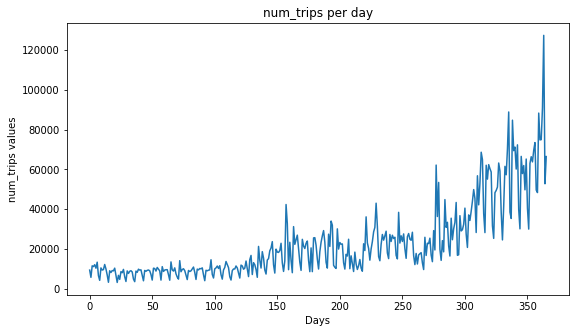

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365
date,2018-04-07 00:00:00,2018-04-08 00:00:00,2018-04-09 00:00:00,2018-04-10 00:00:00,2018-04-11 00:00:00,2018-04-12 00:00:00,2018-04-13 00:00:00,2018-04-14 00:00:00,2018-04-15 00:00:00,2018-04-16 00:00:00,2018-04-17 00:00:00,2018-04-18 00:00:00,2018-04-19 00:00:00,2018-04-20 00:00:00,2018-04-21 00:00:00,2018-04-22 00:00:00,2018-04-23 00:00:00,2018-04-24 00:00:00,2018-04-25 00:00:00,2018-04-26 00:00:00,2018-04-27 00:00:00,2018-04-28 00:00:00,2018-04-29 00:00:00,2018-04-30 00:00:00,2018-05-01 00:00:00,2018-05-02 00:00:00,2018-05-03 00:00:00,2018-05-04 00:00:00,2018-05-05 00:00:00,2018-05-06 00:00:00,2018-05-07 00:00:00,2018-05-08 00:00:00,2018-05-09 00:00:00,2018-05-10 00:00:00,2018-05-11 00:00:00,2018-05-12 00:00:00,2018-05-13 00:00:00,2018-05-14 00:00:00,2018-05-15 00:00:00,2018-05-16 00:00:00,2018-05-17 00:00:00,2018-05-18 00:00:00,2018-05-19 00:00:00,2018-05-20 00:00:00,2018-05-21 00:00:00,2018-05-22 00:00:00,2018-05-23 00:00:00,2018-05-24 00:00:00,2018-05-25 00:00:00,2018-05-26 00:00:00,2018-05-27 00:00:00,2018-05-28 00:00:00,2018-05-29 00:00:00,2018-05-30 00:00:00,2018-05-31 00:00:00,2018-06-01 00:00:00,2018-06-02 00:00:00,2018-06-03 00:00:00,2018-06-04 00:00:00,2018-06-05 00:00:00,2018-06-06 00:00:00,2018-06-07 00:00:00,2018-06-08 00:00:00,2018-06-09 00:00:00,2018-06-10 00:00:00,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00,2018-06-21 00:00:00,2018-06-22 00:00:00,2018-06-23 00:00:00,2018-06-24 00:00:00,2018-06-25 00:00:00,2018-06-26 00:00:00,2018-06-27 00:00:00,2018-06-28 00:00:00,2018-06-29 00:00:00,2018-06-30 00:00:00,2018-07-01 00:00:00,2018-07-02 00:00:00,2018-07-03 00:00:00,2018-07-04 00:00:00,2018-07-05 00:00:00,2018-07-06 00:00:00,2018-07-07 00:00:00,2018-07-08 00:00:00,2018-07-09 00:00:00,2018-07-10 00:00:00,2018-07-11 00:00:00,2018-07-12 00:00:00,2018-07-13 00:00:00,2018-07-14 00:00:00,2018-07-15 00:00:00,2018-07-16 00:00:00,2018-07-17 00:00:00,2018-07-18 00:00:00,2018-07-19 00:00:00,2018-07-20 00:00:00,2018-07-21 00:00:00,2018-07-22 00:00:00,2018-07-23 00:00:00,2018-07-24 00:00:00,2018-07-25 00:00:00,2018-07-26 00:00:00,2018-07-27 00:00:00,2018-07-28 00:00:00,2018-07-29 00:00:00,2018-07-30 00:00:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-02 00:00:00,2018-08-03 00:00:00,2018-08-04 00:00:00,2018-08-05 00:00:00,2018-08-06 00:00:00,2018-08-07 00:00:00,2018-08-08 00:00:00,2018-08-09 00:00:00,2018-08-10 00:00:00,2018-08-11 00:00:00,2018-08-12 00:00:00,2018-08-13 00:00:00,2018-08-14 00:00:00,2018-08-15 00:00:00,2018-08-16 00:00:00,

In [27]:
aggregated_data_visualisations(data_new_aggregated, 'num_trips', None, 9, 5, 'all')
data_new_aggregated[["date","num_trips"]].transpose()

#### Note: Number of trips have increased over days

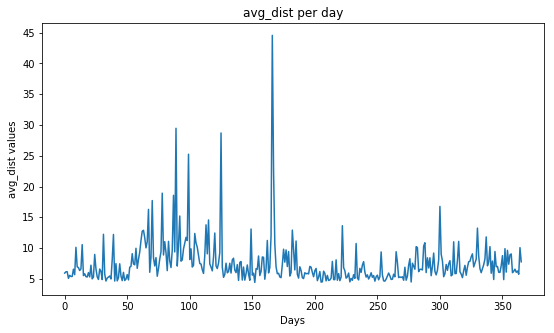

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365
date,2018-04-07 00:00:00,2018-04-08 00:00:00,2018-04-09 00:00:00,2018-04-10 00:00:00,2018-04-11 00:00:00,2018-04-12 00:00:00,2018-04-13 00:00:00,2018-04-14 00:00:00,2018-04-15 00:00:00,2018-04-16 00:00:00,2018-04-17 00:00:00,2018-04-18 00:00:00,2018-04-19 00:00:00,2018-04-20 00:00:00,2018-04-21 00:00:00,2018-04-22 00:00:00,2018-04-23 00:00:00,2018-04-24 00:00:00,2018-04-25 00:00:00,2018-04-26 00:00:00,2018-04-27 00:00:00,2018-04-28 00:00:00,2018-04-29 00:00:00,2018-04-30 00:00:00,2018-05-01 00:00:00,2018-05-02 00:00:00,2018-05-03 00:00:00,2018-05-04 00:00:00,2018-05-05 00:00:00,2018-05-06 00:00:00,2018-05-07 00:00:00,2018-05-08 00:00:00,2018-05-09 00:00:00,2018-05-10 00:00:00,2018-05-11 00:00:00,2018-05-12 00:00:00,2018-05-13 00:00:00,2018-05-14 00:00:00,2018-05-15 00:00:00,2018-05-16 00:00:00,2018-05-17 00:00:00,2018-05-18 00:00:00,2018-05-19 00:00:00,2018-05-20 00:00:00,2018-05-21 00:00:00,2018-05-22 00:00:00,2018-05-23 00:00:00,2018-05-24 00:00:00,2018-05-25 00:00:00,2018-05-26 00:00:00,2018-05-27 00:00:00,2018-05-28 00:00:00,2018-05-29 00:00:00,2018-05-30 00:00:00,2018-05-31 00:00:00,2018-06-01 00:00:00,2018-06-02 00:00:00,2018-06-03 00:00:00,2018-06-04 00:00:00,2018-06-05 00:00:00,2018-06-06 00:00:00,2018-06-07 00:00:00,2018-06-08 00:00:00,2018-06-09 00:00:00,2018-06-10 00:00:00,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00,2018-06-21 00:00:00,2018-06-22 00:00:00,2018-06-23 00:00:00,2018-06-24 00:00:00,2018-06-25 00:00:00,2018-06-26 00:00:00,2018-06-27 00:00:00,2018-06-28 00:00:00,2018-06-29 00:00:00,2018-06-30 00:00:00,2018-07-01 00:00:00,2018-07-02 00:00:00,2018-07-03 00:00:00,2018-07-04 00:00:00,2018-07-05 00:00:00,2018-07-06 00:00:00,2018-07-07 00:00:00,2018-07-08 00:00:00,2018-07-09 00:00:00,2018-07-10 00:00:00,2018-07-11 00:00:00,2018-07-12 00:00:00,2018-07-13 00:00:00,2018-07-14 00:00:00,2018-07-15 00:00:00,2018-07-16 00:00:00,2018-07-17 00:00:00,2018-07-18 00:00:00,2018-07-19 00:00:00,2018-07-20 00:00:00,2018-07-21 00:00:00,2018-07-22 00:00:00,2018-07-23 00:00:00,2018-07-24 00:00:00,2018-07-25 00:00:00,2018-07-26 00:00:00,2018-07-27 00:00:00,2018-07-28 00:00:00,2018-07-29 00:00:00,2018-07-30 00:00:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-02 00:00:00,2018-08-03 00:00:00,2018-08-04 00:00:00,2018-08-05 00:00:00,2018-08-06 00:00:00,2018-08-07 00:00:00,2018-08-08 00:00:00,2018-08-09 00:00:00,2018-08-10 00:00:00,2018-08-11 00:00:00,2018-08-12 00:00:00,2018-08-13 00:00:00,2018-08-14 00:00:00,2018-08-15 00:00:00,2018-08-16 00:00:00,

In [28]:
aggregated_data_visualisations(data_new_aggregated, 'avg_dist', None, 9, 5, 'all')
data_new_aggregated[["date","avg_dist"]].transpose()

#### Note: Avergae distance covered per day is more or less consistent except some days covering more distances

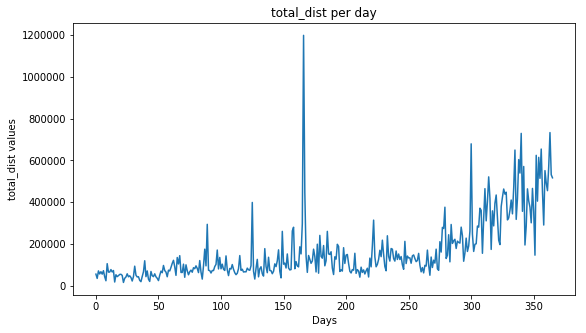

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365
date,2018-04-07 00:00:00,2018-04-08 00:00:00,2018-04-09 00:00:00,2018-04-10 00:00:00,2018-04-11 00:00:00,2018-04-12 00:00:00,2018-04-13 00:00:00,2018-04-14 00:00:00,2018-04-15 00:00:00,2018-04-16 00:00:00,2018-04-17 00:00:00,2018-04-18 00:00:00,2018-04-19 00:00:00,2018-04-20 00:00:00,2018-04-21 00:00:00,2018-04-22 00:00:00,2018-04-23 00:00:00,2018-04-24 00:00:00,2018-04-25 00:00:00,2018-04-26 00:00:00,2018-04-27 00:00:00,2018-04-28 00:00:00,2018-04-29 00:00:00,2018-04-30 00:00:00,2018-05-01 00:00:00,2018-05-02 00:00:00,2018-05-03 00:00:00,2018-05-04 00:00:00,2018-05-05 00:00:00,2018-05-06 00:00:00,2018-05-07 00:00:00,2018-05-08 00:00:00,2018-05-09 00:00:00,2018-05-10 00:00:00,2018-05-11 00:00:00,2018-05-12 00:00:00,2018-05-13 00:00:00,2018-05-14 00:00:00,2018-05-15 00:00:00,2018-05-16 00:00:00,2018-05-17 00:00:00,2018-05-18 00:00:00,2018-05-19 00:00:00,2018-05-20 00:00:00,2018-05-21 00:00:00,2018-05-22 00:00:00,2018-05-23 00:00:00,2018-05-24 00:00:00,2018-05-25 00:00:00,2018-05-26 00:00:00,2018-05-27 00:00:00,2018-05-28 00:00:00,2018-05-29 00:00:00,2018-05-30 00:00:00,2018-05-31 00:00:00,2018-06-01 00:00:00,2018-06-02 00:00:00,2018-06-03 00:00:00,2018-06-04 00:00:00,2018-06-05 00:00:00,2018-06-06 00:00:00,2018-06-07 00:00:00,2018-06-08 00:00:00,2018-06-09 00:00:00,2018-06-10 00:00:00,2018-06-11 00:00:00,2018-06-12 00:00:00,2018-06-13 00:00:00,2018-06-14 00:00:00,2018-06-15 00:00:00,2018-06-16 00:00:00,2018-06-17 00:00:00,2018-06-18 00:00:00,2018-06-19 00:00:00,2018-06-20 00:00:00,2018-06-21 00:00:00,2018-06-22 00:00:00,2018-06-23 00:00:00,2018-06-24 00:00:00,2018-06-25 00:00:00,2018-06-26 00:00:00,2018-06-27 00:00:00,2018-06-28 00:00:00,2018-06-29 00:00:00,2018-06-30 00:00:00,2018-07-01 00:00:00,2018-07-02 00:00:00,2018-07-03 00:00:00,2018-07-04 00:00:00,2018-07-05 00:00:00,2018-07-06 00:00:00,2018-07-07 00:00:00,2018-07-08 00:00:00,2018-07-09 00:00:00,2018-07-10 00:00:00,2018-07-11 00:00:00,2018-07-12 00:00:00,2018-07-13 00:00:00,2018-07-14 00:00:00,2018-07-15 00:00:00,2018-07-16 00:00:00,2018-07-17 00:00:00,2018-07-18 00:00:00,2018-07-19 00:00:00,2018-07-20 00:00:00,2018-07-21 00:00:00,2018-07-22 00:00:00,2018-07-23 00:00:00,2018-07-24 00:00:00,2018-07-25 00:00:00,2018-07-26 00:00:00,2018-07-27 00:00:00,2018-07-28 00:00:00,2018-07-29 00:00:00,2018-07-30 00:00:00,2018-07-31 00:00:00,2018-08-01 00:00:00,2018-08-02 00:00:00,2018-08-03 00:00:00,2018-08-04 00:00:00,2018-08-05 00:00:00,2018-08-06 00:00:00,2018-08-07 00:00:00,2018-08-08 00:00:00,2018-08-09 00:00:00,2018-08-10 00:00:00,2018-08-11 00:00:00,2018-08-12 00:00:00,2018-08-13 00:00:00,2018-08-14 00:00:00,2018-08-15 00:00:00,2018-08-16 00:00:00,

In [29]:
aggregated_data_visualisations(data_new_aggregated, 'total_dist', None, 9, 5, 'all') 
data_new_aggregated[["date","total_dist"]].transpose()

#### Note: Total distance covered per day has icnreased over days

/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


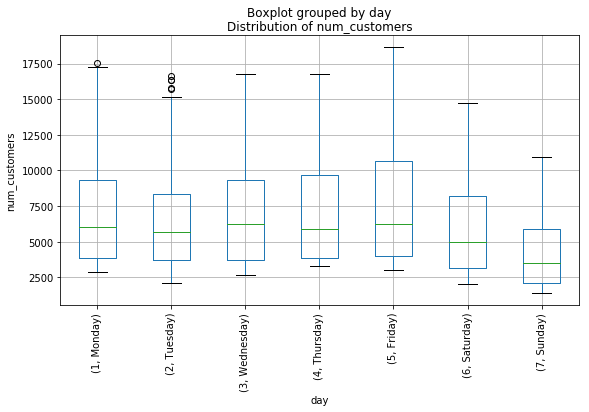

In [30]:
aggregated_data_visualisations(data_new_aggregated, 'num_customers', 'day', 9, 5, 'not-all')

#### Note: Number of customers on Fridays are higher

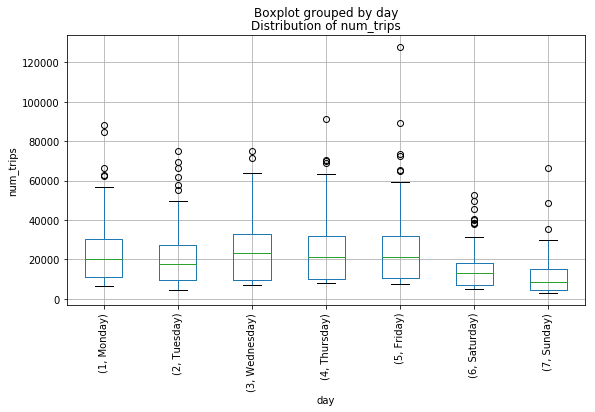

In [31]:
aggregated_data_visualisations(data_new_aggregated, 'num_trips', 'day', 9, 5, 'not-all')

#### Note: Number of trips on Wednesday, Thursday and Friday are higher

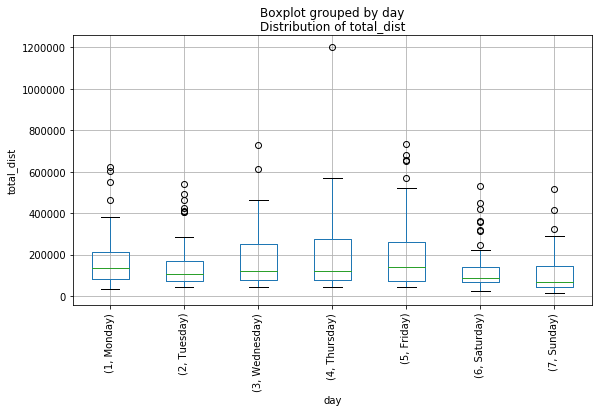

In [32]:
aggregated_data_visualisations(data_new_aggregated, 'total_dist', 'day', 9, 5, 'not-all') 

#### Note: Total distance covered during Wednesday, Thursday and Friday are higher

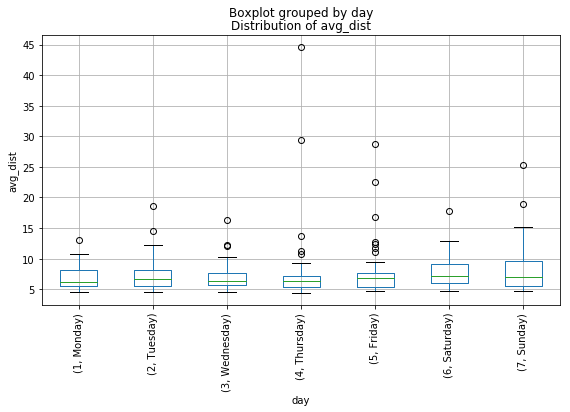

In [33]:
aggregated_data_visualisations(data_new_aggregated, 'avg_dist', 'day', 9, 5, 'not-all') 

#### Note: Average distance over days remain consistent on most days

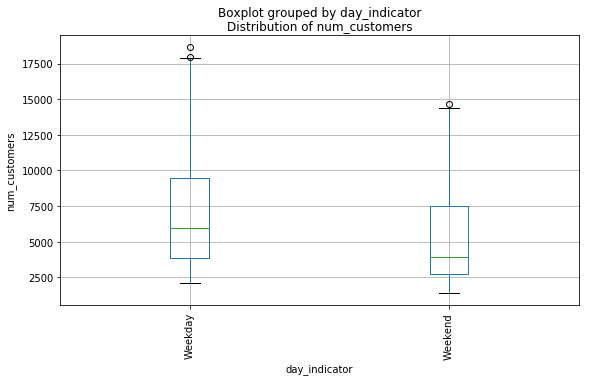

In [34]:
aggregated_data_visualisations(data_new_aggregated, 'num_customers', 'day_indicator', 9, 5, 'not-all')

#### Note: More number of customers travel during Weekdays compared to Weekends

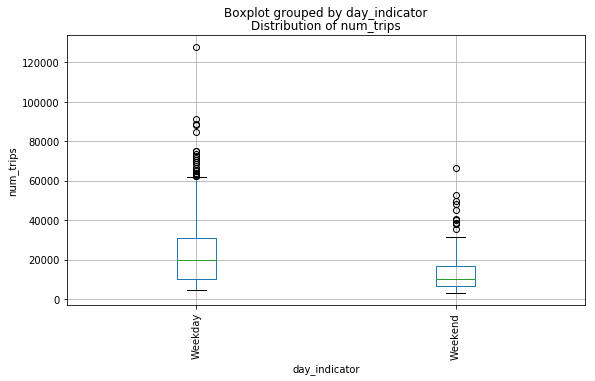

In [35]:
aggregated_data_visualisations(data_new_aggregated, 'num_trips', 'day_indicator', 9, 5, 'not-all')

#### Note: More number of trips take place during Weekdays compared to Weekends

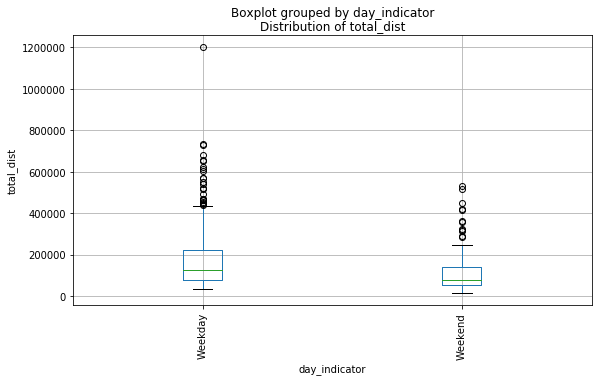

In [36]:
aggregated_data_visualisations(data_new_aggregated, 'total_dist', 'day_indicator', 9, 5, 'not-all') 

#### Note: Total distance covered during Weekdays are higher compared to Weekends

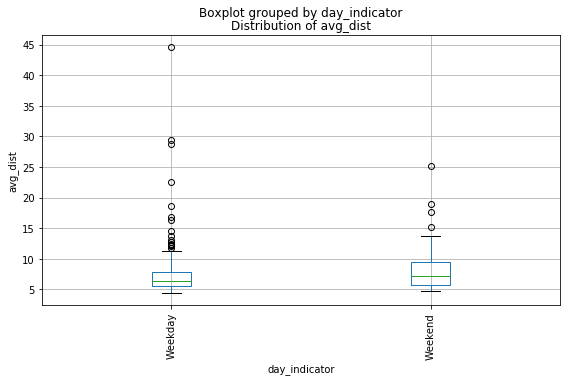

In [37]:
aggregated_data_visualisations(data_new_aggregated, 'avg_dist', 'day_indicator', 9, 5, 'not-all') 

#### Note: Avergae distance travelled during Weekends are higher than Weekdays

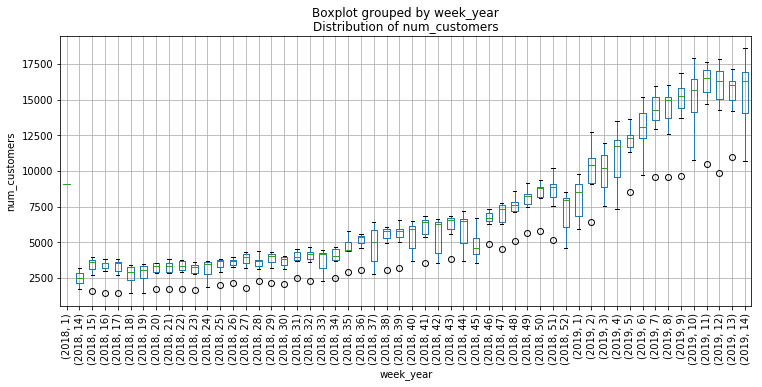

In [38]:
aggregated_data_visualisations(data_new_aggregated, 'num_customers', 'week_year', 12, 5, 'not-all')

#### Note: Number of customers has increased over the weeks

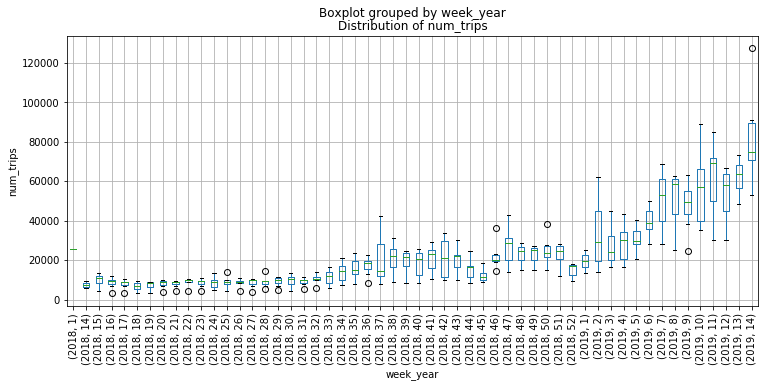

In [39]:
aggregated_data_visualisations(data_new_aggregated, 'num_trips', 'week_year', 12, 5, 'not-all')

#### Note: Number of trips has increased over the weeks

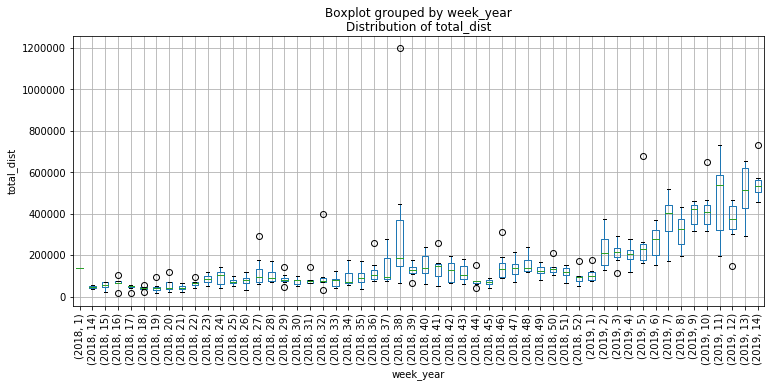

In [40]:
aggregated_data_visualisations(data_new_aggregated, 'total_dist', 'week_year', 12, 5, 'not-all') 

#### Note: Total distance covered per week has increased over time

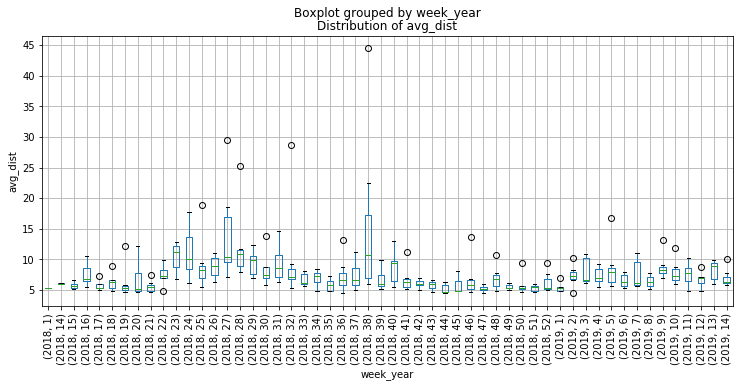

In [41]:
aggregated_data_visualisations(data_new_aggregated, 'avg_dist', 'week_year', 12, 5, 'not-all') 

#### Note: Average distance covered over weeks remain moderately consistent

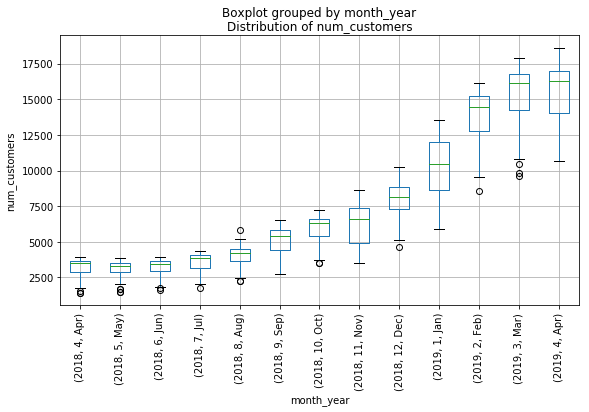

In [42]:
aggregated_data_visualisations(data_new_aggregated, 'num_customers', 'month_year', 9, 5, 'not-all')

#### Note: Year-month level view of trend of number of customers

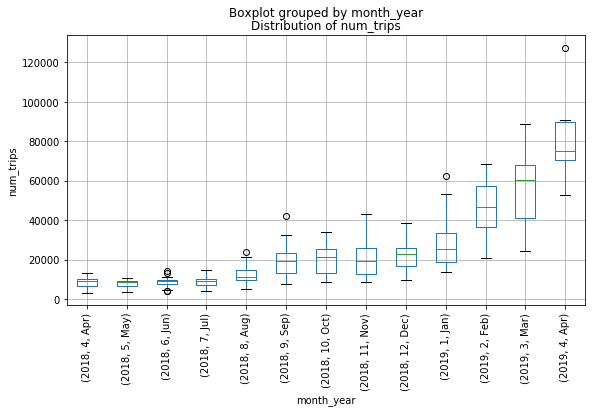

In [43]:
aggregated_data_visualisations(data_new_aggregated, 'num_trips', 'month_year', 9, 5, 'not-all')

#### Note: Year-month level view of trend of number of trips

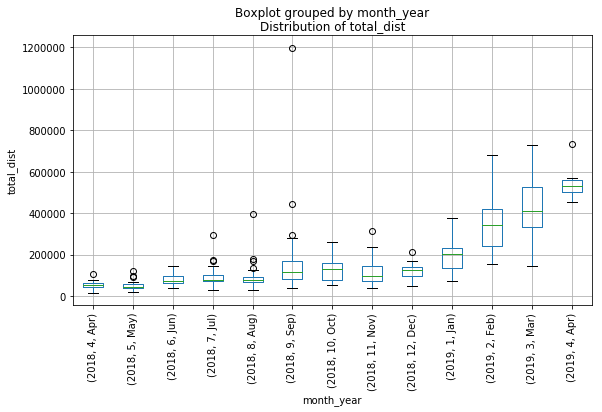

In [44]:
aggregated_data_visualisations(data_new_aggregated, 'total_dist', 'month_year', 9, 5, 'not-all') 

#### Note: Year-month level view of total distance covered

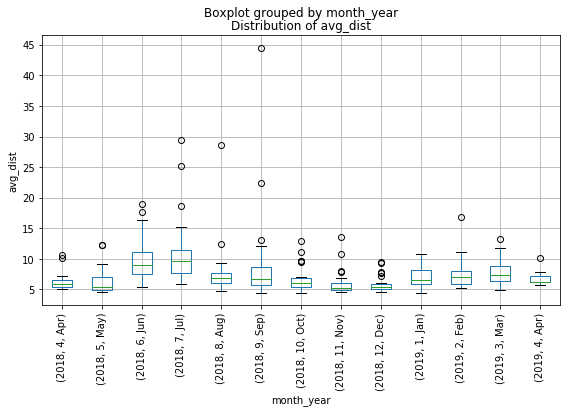

In [45]:
aggregated_data_visualisations(data_new_aggregated, 'avg_dist', 'month_year', 9, 5, 'not-all') 

#### Note: Year-month level view of average distance covered

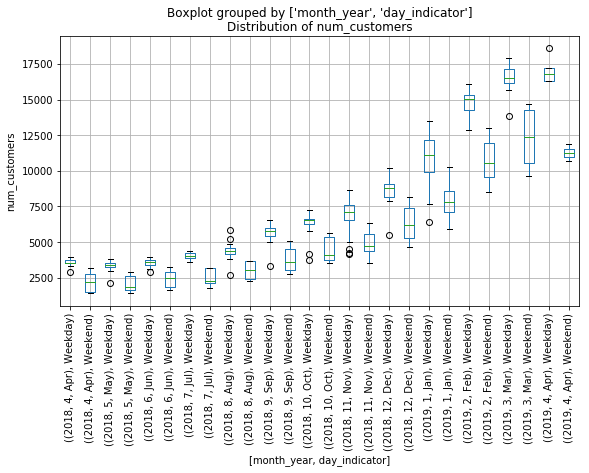

In [46]:
aggregated_data_visualisations(data_new_aggregated, 'num_customers', ['month_year', 'day_indicator'], 9, 5, 'not-all')

#### Note: <br> i. Weekend-Weekday trend of number of customers over different months <br> ii. Trend over Weekdays is higher compared to Weekends

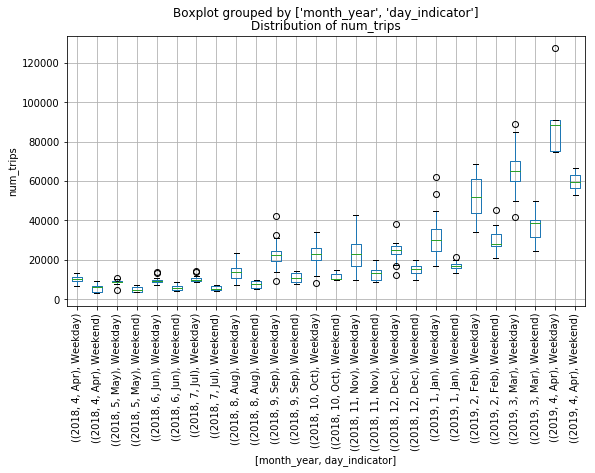

In [47]:
aggregated_data_visualisations(data_new_aggregated, 'num_trips', ['month_year', 'day_indicator'], 9, 5, 'not-all')

#### Note: <br> i. Weekend-Weekday trend of number of trips over different months <br> ii. Trend over Weekdays is higher compared to Weekends

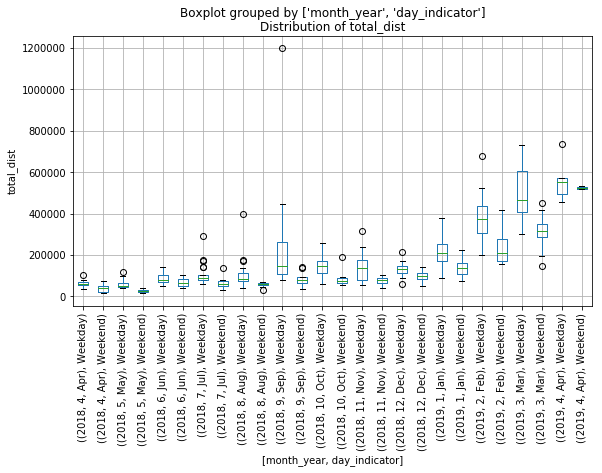

In [48]:
aggregated_data_visualisations(data_new_aggregated, 'total_dist', ['month_year', 'day_indicator'], 9, 5, 'not-all') 

#### Note: <br> i. Weekend-Weekday trend of total distance covered over different months <br> ii. Trend over Weekdays is higher compared to Weekends

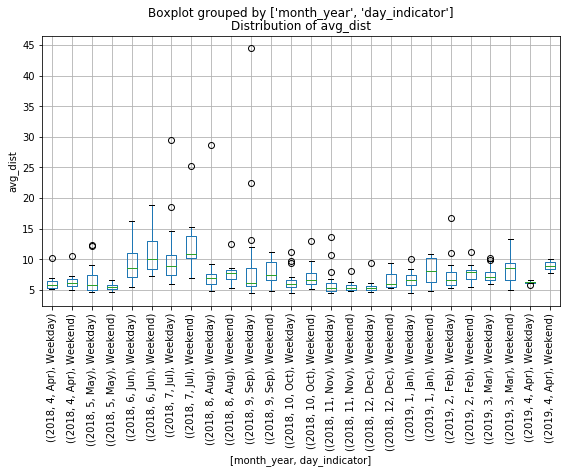

In [49]:
aggregated_data_visualisations(data_new_aggregated, 'avg_dist', ['month_year', 'day_indicator'], 9, 5, 'not-all') 

#### Note: <br> i. Weekend-Weekday trend of average distance covered over different months <br> ii. Trend of avergae distance is more or less similar

#### From the EDA, an increasing relationship of number of trips have been observed for the following features: <br> i. With time [timestamp indicator] <br> ii. Day of the week <br> iii. Weekend/Weekday <br> iv. Week  <br> v. Month

### Data preparation to prepare future demand (number of trips)

In [50]:
data_new_aggregated = remove_outliers(data_new_aggregated, 'num_trips')

target = pd.DataFrame(data_new_aggregated["num_trips"])
features = data_new_aggregated[["ts_indicator", 'day_no', "day_indicator", "week_no", 'month_name']]


 IQR 18548.0 
 Lower limit -18278.0
 Upper limit 55914.0

 Minimum 3118 
 Maximum 127507 

There are samples which violate only upper limit
Outliers have been removed


#### Note: Learning get influenced by presence of outliers, hence removed

### Encoding categorical features

In [51]:
features = categorical_encode(features, 'month_name' ,'l_encode')
features = categorical_encode(features, 'day_indicator' ,'l_encode')

### Checking correlation of features with target

In [52]:
x = pd.concat([features,target], axis=1)
x_corr = x.corr()
x_corr

,ts_indicator,day_no,week_no,month_name_encoded,day_indicator_encoded,num_trips
ts_indicator,1.000000,0.071158,-0.019389,0.033889,0.099186,0.775945
day_no,0.071158,1.000000,-0.048500,-0.003632,0.806622,-0.176293
week_no,-0.019389,-0.048500,1.000000,0.304943,-0.076152,-0.183839
month_name_encoded,0.033889,-0.003632,0.304943,1.000000,-0.011235,0.017352
day_indicator_encoded,0.099186,0.806622,-0.076152,-0.011235,1.000000,-0.204762
num_trips,0.775945,-0.176293,-0.183839,0.017352,-0.204762,1.000000


#### Note: Correlation is used to verify linearity

### Preparing test and train data

In [53]:
data_tr_X = features.iloc[0:320]
data_tr_Y = target.iloc[0:320]

In [54]:
data_tt_X = features.iloc[320:]
data_tt_X = data_tt_X.reset_index()
data_tt_X.drop(['index'], axis = 1, inplace = True)

data_tt_Y = target.iloc[320:]
data_tt_Y = data_tt_Y.reset_index()
data_tt_Y.drop(['index'], axis = 1, inplace = True)

### Modeling

In [55]:
data_tr_X = sm.add_constant(data_tr_X)
data_tt_X = sm.add_constant(data_tt_X)

model = sm.OLS(data_tr_Y, data_tr_X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              num_trips   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     149.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           6.26e-81
Time:                        23:36:31   Log-Likelihood:                -3228.4
No. Observations:                 320   AIC:                             6469.
Df Residuals:                     314   BIC:                             6491.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  8378.94

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Predicting on train and test data

In [56]:
pred_tt = results.predict(data_tt_X)
pred_tt_f = pd.concat([pd.DataFrame(data_tt_Y), pd.DataFrame(pred_tt)], axis = 1)
pred_tt_f.columns = ['num_trips_original', 'num_trips_predicted']

pred_tr = results.predict(data_tr_X)
pred_tr_f = pd.concat([pd.DataFrame(data_tr_Y), pd.DataFrame(pred_tr)], axis = 1)
pred_tr_f.columns = ['num_trips_original', 'num_trips_predicted']

print("Train error (MAE): ",metrics.mean_absolute_error(pred_tr_f["num_trips_original"], pred_tr_f["num_trips_predicted"]))
print("Test error (MAE): ",metrics.mean_absolute_error(pred_tt_f["num_trips_original"], pred_tt_f["num_trips_predicted"]))

Train error (MAE):  4235.804987385943
Test error (MAE):  9307.120242814131


#### Note: Both train and test errors are high. Model is underfitting.

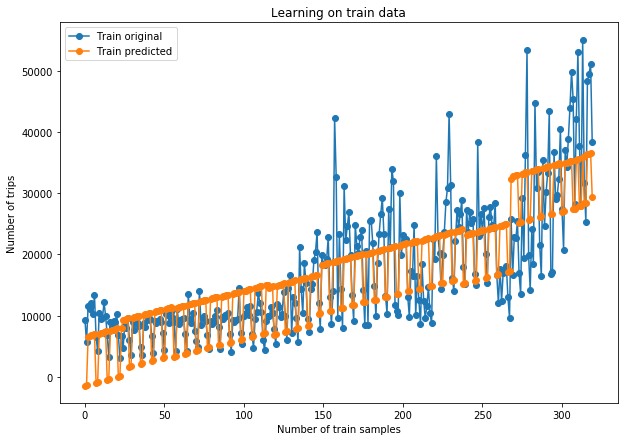

In [57]:
plt.figure(figsize = (10,7))
plt.plot(pred_tr_f["num_trips_original"], label = 'Train original', marker='o')
plt.plot(pred_tr_f["num_trips_predicted"], label = 'Train predicted', marker='o')
plt.title("Learning on train data")
plt.xlabel("Number of train samples")
plt.ylabel("Number of trips")
plt.legend()
plt.show()

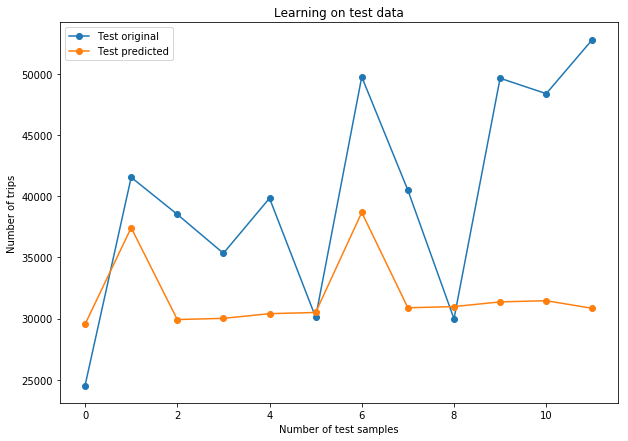

In [58]:
plt.figure(figsize = (10,7))
plt.plot(pred_tt_f["num_trips_original"], label = 'Test original', marker='o')
plt.plot(pred_tt_f["num_trips_predicted"], label = 'Test predicted', marker='o')
plt.title("Learning on test data")
plt.xlabel("Number of test samples")
plt.ylabel("Number of trips")
plt.legend()
plt.show()

## Report and future steps

### The original dataset contains ~8 million records of customer ID, pick-up, drop-off points and timestamp. To get meaningful insights from this data, some adjustments have been done. <br><br> The pick-up, drop-off locations have been used to compute ditances covered by the cab service. Timestamp information has been used to extract year, month, week, day, hour information and data has been aggregated at a day level. <br><br> Trend of number of customers, numbner of trips, total distance covered, avergae distance covered have been observed. <br><br> From the EDA, it is observed that number of trips increases over time. There are more number of trips over Weekdays compared to Weekends, Fridays over other days. Thus the final set of features have been chosen. <br><br> Categorical features have been encoded, correlation has been observed to determine strength of linear relationship and outliers have been removed. <br><br> To predict future demands/number of trips, given a small dataset at day level (~300 days), a simple model is chosen for learning since complex models often overfit less amount of data. <br><br> OLS model has R-square value 0f 0.7 i.e. 70% of the variance in the data has been captured by this model. <br><br> The train and test errors are high, indicating an underfit. <br><br> Underfitting can be addressed in certain ways - changing features, using more features, getting more historical data to learn seasonal trends etc. 